[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jonarod/Bootcamp-Inteligencia-Artificial-Women-Who-Code-Medellin/blob/master/semana%203/CNN%20clasificacion/Transfer%20Learning/traffic_signs_Mobilenet_transfer_GPU.ipynb)

## Activar y probar el GPU

Primero, activar el GPU para el notebook:

- En Edit→Notebook Settings
- seleccionar GPU como Accelerador

Luego, probemos que el notebook reconozca el uso del GPU:

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('NO GPU')
print('GPU encontrado: {}'.format(device_name))

GPU encontrado: /device:GPU:0


In [1]:
# Importamos archivo 'kaggle.json' que toca bajar en kaggle.com en su propia cuenta (account > api keys > download api_key)
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


In [ ]:
!kaggle datasets list -s gtsrb-german-traffic-sign

ref                                                                         title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34          54791        807  0.8235294        
datasets/valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11           7838        221  1.0              
datasets/eunjurho/german-traffic-sign-recognition-benchmark-cropped         german_traffic_sign_recognition_benchmark_cropped  206MB  2019-11-10 15:22:13            269          7  0.75             
datas

In [ ]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign  
%cd ..

 99% 604M/612M [00:02<00:00, 224MB/s]
100% 612M/612M [00:02<00:00, 215MB/s]
/content


In [ ]:
!cd traffic_sign_dataset/ && ls

gtsrb-german-traffic-sign.zip


In [ ]:
# Unzip archivos y borrar archivos inutiles
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv

Streaming output truncated to the last 5000 lines.
  inflating: traffic_sign_dataset/train/5/00005_00053_00010.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00011.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00012.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00013.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00014.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00015.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00016.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00017.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00018.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00019.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00020.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00021.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00022.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00023.png  
  inflating: traffic_sign

In [ ]:
!ls ./traffic_sign_dataset/Train

0   11	14  17	2   22	25  28	30  33	36  39	41  6  9
1   12	15  18	20  23	26  29	31  34	37  4	42  7
10  13	16  19	21  24	27  3	32  35	38  40	5   8


In [ ]:
!ls ./traffic_sign_dataset/Train/0

00000_00000_00000.png  00000_00002_00010.png  00000_00004_00020.png
00000_00000_00001.png  00000_00002_00011.png  00000_00004_00021.png
00000_00000_00002.png  00000_00002_00012.png  00000_00004_00022.png
00000_00000_00003.png  00000_00002_00013.png  00000_00004_00023.png
00000_00000_00004.png  00000_00002_00014.png  00000_00004_00024.png
00000_00000_00005.png  00000_00002_00015.png  00000_00004_00025.png
00000_00000_00006.png  00000_00002_00016.png  00000_00004_00026.png
00000_00000_00007.png  00000_00002_00017.png  00000_00004_00027.png
00000_00000_00008.png  00000_00002_00018.png  00000_00004_00028.png
00000_00000_00009.png  00000_00002_00019.png  00000_00004_00029.png
00000_00000_00010.png  00000_00002_00020.png  00000_00005_00000.png
00000_00000_00011.png  00000_00002_00021.png  00000_00005_00001.png
00000_00000_00012.png  00000_00002_00022.png  00000_00005_00002.png
00000_00000_00013.png  00000_00002_00023.png  00000_00005_00003.png
00000_00000_00014.png  00000_00002_00024.png  00

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

traffic_signs_dir = os.path.join('./traffic_sign_dataset/Train')


# En vez de importar las imagenes manualmente, creamos un generador de imagenes
# El generador de keras puede AUMENTAR imagenes por cada batch
# En este caso no lo usamos, pero existe la posibilidad de configurar distorcion, re-orientacion, y mulitiples 
# otras estrategias de aumentacion de imagenes para alimentar el modelo con "nuevas" imagenes
# (recordemos que para una computadora, una imagen es "nueva" desde el momento que se le cambia 1 pixel...)

datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    traffic_signs_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    traffic_signs_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 43))

In [ ]:
print(train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('traffic_signs_labels.txt', 'w') as f:
  f.write(labels)

{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42}


In [ ]:
!cat traffic_signs_labels.txt

0
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
33
34
35
36
37
38
39
4
40
41
42
5
6
7
8
9

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# AQUI ES DONDE IMPORTAMOS EL MODELO "MOBILENET" PRE-ENTRENADO POR GOOGLE

# IMPORTANTE: aqui pedimos importar SIN LA CABEZA del modelo (include_top=False) es decir sin la capa de salida
# Tambien le pedimos el modelo pre-entrenado con el dataset 'imagenet'
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# IMPORTANTE: le imponemos de congelar los pesos del modelo que acabamos de importar (en la variable 'base_model')
# Es decir que todos los pesos del modelo no seran actualizados durante el entrenamiento:
# solo NUESTRO MODELO, que pegaremos encima del pre-entrenado, sera realmente entrenado, 
# pero usando la ultima capa escondida de Mobilenet como capa de entrada para nuestro modelo.
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Aqui construimos NUESTRO modelo especefico para nuestro problema (senales de transito)
model = tf.keras.Sequential([
  base_model, # Aqui el modelo preentrenado
  
  # A partir de aqui NUESTRO modelo
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=43, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 43)                1419      
                                                                 
Total params: 2,628,075
Trainable params: 370,091
Non-tr

In [ ]:
# Entrenamos el modelo
# Observan el uso de los generadores aqui
history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=val_generator, validation_steps=len(val_generator))

Epoch 1/10
491/491 [==============================] - 116s 207ms/step - loss: 1.3948 - accuracy: 0.5998 - val_loss: 1.3358 - val_accuracy: 0.6137
Epoch 2/10
491/491 [==============================] - 99s 202ms/step - loss: 0.6144 - accuracy: 0.7989 - val_loss: 1.3331 - val_accuracy: 0.6506
Epoch 3/10
491/491 [==============================] - 99s 202ms/step - loss: 0.4550 - accuracy: 0.8524 - val_loss: 1.2854 - val_accuracy: 0.6572
Epoch 4/10
491/491 [==============================] - 99s 202ms/step - loss: 0.3608 - accuracy: 0.8809 - val_loss: 1.3043 - val_accuracy: 0.6724
Epoch 5/10
491/491 [==============================] - 99s 202ms/step - loss: 0.3026 - accuracy: 0.9002 - val_loss: 1.4054 - val_accuracy: 0.6606
Epoch 6/10
491/491 [==============================] - 99s 201ms/step - loss: 0.2730 - accuracy: 0.9098 - val_loss: 1.5165 - val_accuracy: 0.6609
Epoch 7/10
491/491 [==============================] - 99s 202ms/step - loss: 0.2456 - accuracy: 0.9193 - val_loss: 1.4841 - val_a

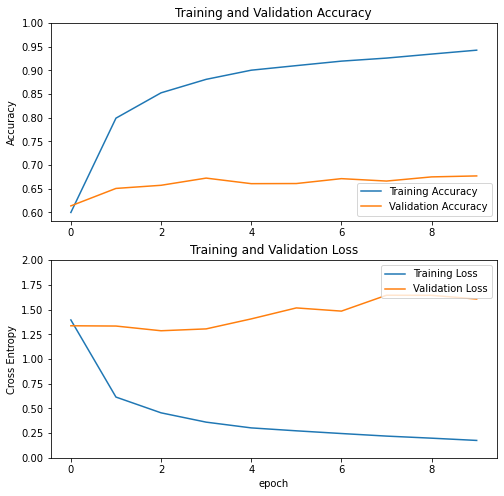

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

No esta nada lindo esa evaluacion (overfit + ninguna convergencia)
Podemos concluir que ha sido un experimento fallado por el momento, pero no aqui uno no sacaria conclusiones igual.
De hecho el Transfer Learning no es siempre la mejor respuesta sobretodo con problemas faciles (senales de transito es un problema considerado relativamente facil en comparacion con imagenet por ejemplo).
Existen estrategias para mejorar esos resultados usando transfer learning:
- Usar dropout para eleminar unos neurones
- Regularizacion L1/L2
- Batch Normalizacion
- Aumentar el numero de imagenes
- DES-Congelar los pesos del modelo pre-entrenado: eso obviamente implica mucho mas tiempo de entrenamiento, pero es una estrategia muy viable porque los pesos del modelo (como Mobilenet aqui) estando pre-entrenados significa es mucho mejor que empezar desde pesos aleatorios y eso significa unas chances de convergencias relativamente rapidos pero seguramente mucho mas rapido que empezar desde zero.
- Cirurjia de modelos: es decir entrar en el modelo original para agregar/modificar/sacar neurones especificos (no recomendado, generalmente muy dificil y contraproducente)
- Cambiar de modelo pre-entrenado con uno mas cerca de nuestro problema. Tambien existe la posibilidad de importar el mismo modelo pero con pesos de otros datos (por ejemplo importando los pesos de CIFAR-10 en vez de IMAGENET) 
